# time series classification

### 1. Загрузка библиотек

In [1]:
# import warnings
# warnings.filterwarnings('ignore')
import sys
# print(sys.version, sys.platform, sys.executable)
from tqdm import tqdm 
import colorama as color
import os
import time
import math
from scipy.stats import norm
from sklearn.base import clone

# data
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# sktime
from sktime.datasets import load_airline, load_arrow_head
# tslearn
from tslearn.utils import to_time_series, to_time_series_dataset, save_time_series_txt, load_time_series_txt
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError, mean_absolute_percentage_error

# model
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
# sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
# tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
# tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers

np.random.seed(42)


In [2]:
def cm_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # Normalize
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cmn, cmap = 'Blues', annot = True, fmt = '.2f')
    sns.set(font_scale=1.3)
    plt.title('Confusion Matrix')
    return plt.show()

def print_table(accuracies, times):
    """Utility function to pretty print the obtained accuracies"""
    header_str = '|'
    header_str += '{:^20}|'.format('dataset')
    columns = ['sax error', 'sax time', 'eucl error', 'eucl time']
    for col in columns:
        header_str += '{:^12}|'.format(col)
    print(header_str)
    print('-'*(len(columns) * 13 + 22))

    for dataset in accuracies:
        acc_sax, acc_euclidean = accuracies[dataset]
        time_sax, time_euclidean = times[dataset]
        sax_error = np.around(1 - acc_sax, 5)
        eucl_error = np.around(1 - acc_euclidean, 5)
        time_sax = np.around(time_sax, 5)
        time_euclidean = np.around(time_euclidean, 5)
        s = '|'
        s += '{:>20}|'.format(dataset)
        s += '{:>12}|'.format(sax_error)
        s += '{:>12}|'.format(time_sax)
        s += '{:>12}|'.format(eucl_error)
        s += '{:>12}|'.format(time_euclidean)
        print(s.strip())

    print('-'*(len(columns) * 13 + 22))

def load_data_ecg():
  X_train = np.load('data/train_x.npy')
  X_test_real = np.load('data/test_x.npy')
  y_train = np.load('data/train_y.npy')
  print(X_train.shape, y_train.shape)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state=42)
  print(X_train.shape, y_train.shape)
  return X_train, X_test, y_train, y_test

## sktime airline and arrow head

### 2. Загрузка данных и разделение на тренировочную и тестовую выборку

In [15]:
# forecasting
data = load_airline()
print(data.shape)

# classification
X, y = load_arrow_head(return_X_y=True)
X_train , X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape)

(144,)
(158, 1) (158,)


In [11]:
data

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

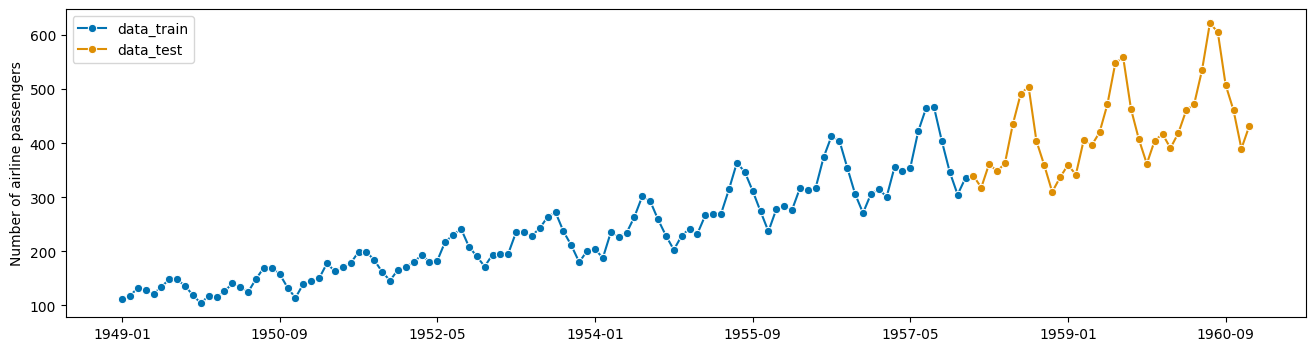

In [3]:
data_train, data_test = temporal_train_test_split(data)
plot_series(data_train, data_test, labels = ['data_train','data_test'])

In [12]:
X_train

,dim_0
120,0 -1.762354 1 -1.758315 2 -1.74198...
200,0 -1.805452 1 -1.798470 2 -1.76056...
156,0 -2.068266 1 -2.049443 2 -1.99982...
93,0 -1.803146 1 -1.800974 2 -1.78802...
0,0 -1.963009 1 -1.957825 2 -1.95614...
...,...
197,0 -0.658001 1 -0.636185 2 -0.60565...
110,0 -1.891357 1 -1.889370 2 -1.85313...
162,0 -1.829802 1 -1.843286 2 -1.81316...
13,0 -1.900535 1 -1.882731 2 -1.86845...


In [13]:
y_train

array(['1', '2', '1', '0', '0', '2', '2', '1', '1', '1', '1', '0', '1',
       '2', '0', '0', '0', '1', '0', '2', '2', '2', '1', '0', '1', '2',
       '0', '0', '0', '1', '2', '2', '0', '1', '1', '0', '1', '1', '1',
       '0', '2', '2', '0', '0', '2', '2', '1', '0', '1', '1', '2', '0',
       '0', '0', '0', '0', '1', '2', '2', '2', '1', '1', '1', '0', '1',
       '1', '0', '0', '0', '0', '2', '0', '0', '0', '0', '2', '0', '0',
       '0', '1', '0', '2', '2', '0', '1', '2', '0', '0', '1', '2', '1',
       '2', '1', '2', '0', '1', '0', '0', '1', '2', '2', '2', '0', '2',
       '1', '1', '0', '1', '0', '1', '2', '1', '1', '2', '0', '1', '2',
       '0', '0', '2', '0', '1', '0', '1', '2', '0', '0', '1', '0', '2',
       '2', '0', '1', '2', '0', '0', '1', '1', '0', '0', '2', '0', '1',
       '2', '0', '2', '2', '1', '2', '2', '1', '2', '0', '2', '1', '2',
       '1', '1'], dtype='<U1')

### 3. Эксперименты по прогнозированию

##### 3.1 Наивный баейсовский алгоритм

0.19886711926999853
0.23195770387951434
0.13189432350948402
0.145427686270316


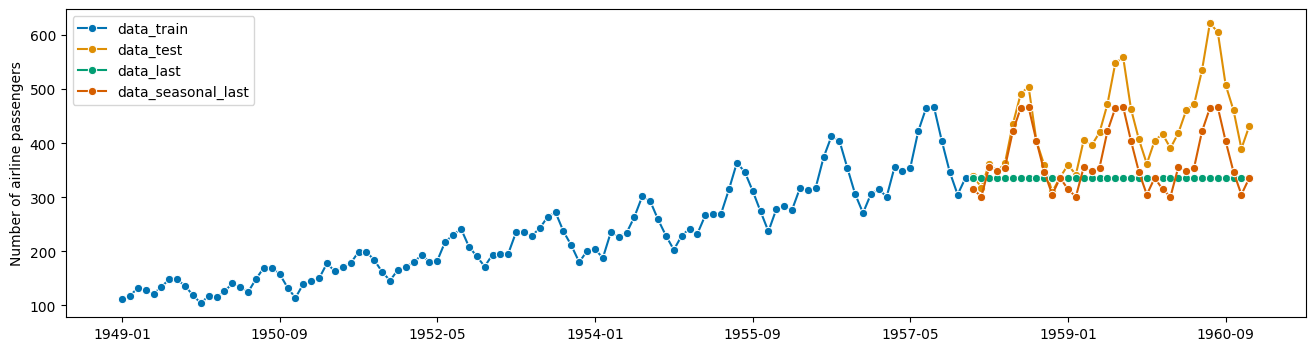

In [4]:
naive_forecaster_last = NaiveForecaster(strategy = 'last')
naive_forecaster_last.fit(data_train)

naive_forecaster_seasonal_last = NaiveForecaster(strategy = 'last', sp = 12) # 12 месяцев
naive_forecaster_seasonal_last.fit(data_train)

fh = ForecastingHorizon(data_test.index, is_relative=False) # fh = np.arange(len(y_test)) + 1  # forecasting horizon

data_last = naive_forecaster_last.predict(fh)
data_seasonal_last = naive_forecaster_seasonal_last.predict(fh)

plot_series(data_train, data_test, data_last, data_seasonal_last, labels = ['data_train', 'data_test', 'data_last', 'data_seasonal_last'])
print(mean_absolute_percentage_error(data_test, data_last, symmetric=False))
print(mean_absolute_percentage_error(data_test, data_last, symmetric=True))
print(mean_absolute_percentage_error(data_test, data_seasonal_last, symmetric=False))
print(mean_absolute_percentage_error(data_test, data_seasonal_last, symmetric=True))


##### 3.2 Взаимодействие с sklearn

0.12812287415313517


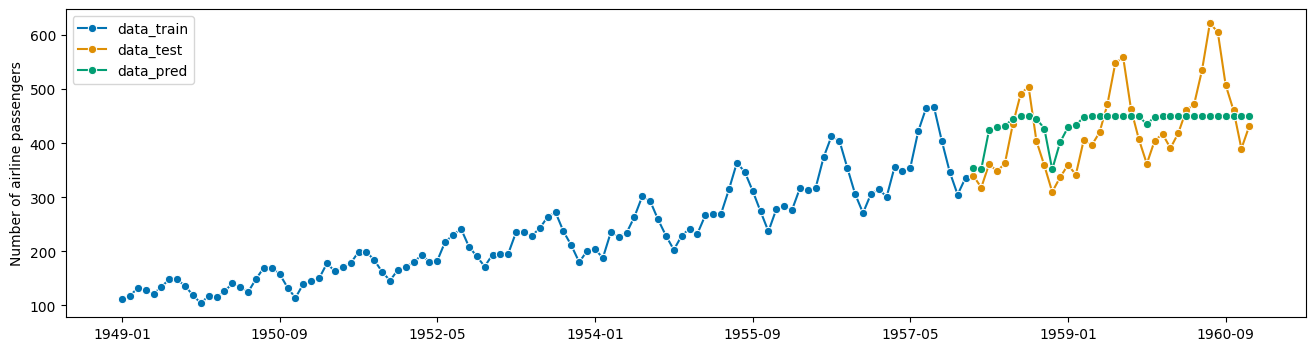

In [5]:
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, window_length=12, strategy='recursive')
forecaster.fit(data_train)
data_pred = forecaster.predict(fh)

plot_series(data_train, data_test, data_pred, labels = ['data_train', 'data_test', 'data_pred'])
print(mean_absolute_percentage_error(data_test, data_pred, symmetric=False))


#### 3.3 AutoARIMA

0.04166964128285063


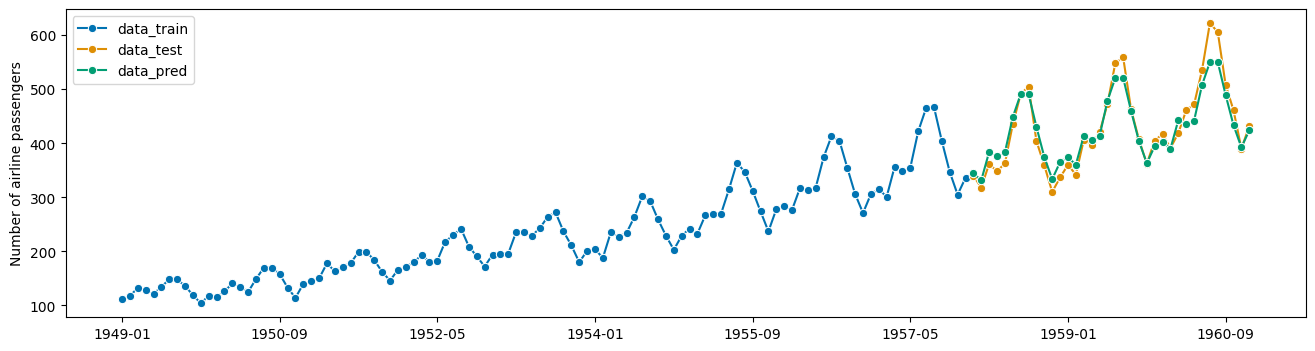

In [8]:
forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
forecaster.fit(data_train)
data_pred = forecaster.predict(fh)
plot_series(data_train, data_test, data_pred, labels=["data_train", "data_test", "data_pred"]);
print(mean_absolute_percentage_error(data_test, data_pred, symmetric=False))


### 4. Эксперименты по классификации

#### 4.1 Классификация одиночных временных рядов

In [16]:
clf = TimeSeriesForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8301886792452831

## tslearn UCR_UEA

### 2.1 Преобразование list в numpy (time series)


In [47]:
ts_0 = [1, 3, 4, 2] # time seires - list
ts_1 = [1, 2, 4, 2]
ts_2 = [1, 2, 3, 3, 3, -1]
ts_3 = [0, 3, 6]

formatted_ts_3 = to_time_series(ts_3)
formatted_ts_0 = to_time_series(ts_0)
formatted_ts_1 = to_time_series(ts_1)
formatted_ts_2 = to_time_series(ts_2)
print(formatted_ts_0)
print(type(formatted_ts_0), formatted_ts_0.shape)

formatted_dataset_0 = to_time_series_dataset([ts_0, ts_1])
print(formatted_dataset_0)
print(type(formatted_dataset_0), formatted_dataset_0.shape)

formatted_dataset_1 = to_time_series_dataset([ts_0, ts_1, ts_2])
print(formatted_dataset_1)
print(type(formatted_dataset_1), formatted_dataset_1.shape)

[[1.]
 [3.]
 [4.]
 [2.]]
<class 'numpy.ndarray'> (4, 1)
[[[1.]
  [3.]
  [4.]
  [2.]]

 [[1.]
  [2.]
  [4.]
  [2.]]]
<class 'numpy.ndarray'> (2, 4, 1)
[[[ 1.]
  [ 3.]
  [ 4.]
  [ 2.]
  [nan]
  [nan]]

 [[ 1.]
  [ 2.]
  [ 4.]
  [ 2.]
  [nan]
  [nan]]

 [[ 1.]
  [ 2.]
  [ 3.]
  [ 3.]
  [ 3.]
  [-1.]]]
<class 'numpy.ndarray'> (3, 6, 1)


In [76]:
print(formatted_ts_0)
print(' ')
print(TimeSeriesScalerMinMax(value_range = (0., 1.)).fit_transform([formatted_ts_0])) # На вход подается множество временных рядов
print(' ')
print(TimeSeriesScalerMinMax(value_range = (1., 2.)).fit_transform([formatted_ts_3]))
print(' ')
print(TimeSeriesScalerMinMax(value_range = (1., 2.)).fit_transform(formatted_dataset_1))

[[1.]
 [3.]
 [4.]
 [2.]]
 
[[[0.        ]
  [0.66666667]
  [1.        ]
  [0.33333333]]]
 
[[[1. ]
  [1.5]
  [2. ]]]
 
[[[1.        ]
  [1.66666667]
  [2.        ]
  [1.33333333]
  [       nan]
  [       nan]]

 [[1.        ]
  [1.33333333]
  [2.        ]
  [1.33333333]
  [       nan]
  [       nan]]

 [[1.5       ]
  [1.75      ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.        ]]]


In [75]:
print(formatted_ts_0)
print(' ')
tssmv = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform([ts_0]) # mu - среднее значение выходного временного ряда, std - стандартное отклонение выходного временного ряда
mu = tssmv.sum() / 4.
print(tssmv, mu, '\n', ' ')
print(TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform([formatted_ts_0])) # mu - среднее значение выходного временного ряда, std - стандартное отклонение выходного временного ряда

[[1.]
 [3.]
 [4.]
 [2.]]
 
[[[-1.34164079]
  [ 0.4472136 ]
  [ 1.34164079]
  [-0.4472136 ]]] -1.3877787807814457e-17 
  
[[[-1.34164079]
  [ 0.4472136 ]
  [ 1.34164079]
  [-0.4472136 ]]]


In [78]:
print(formatted_ts_0)
print(' ')
print(TimeSeriesResampler(sz=5).fit_transform([ts_0]))
print(' ')
print(TimeSeriesResampler(sz=10).fit_transform([ts_0]))
print(' ')
print(TimeSeriesResampler(sz=6).fit_transform(formatted_dataset_1))


[[1.]
 [3.]
 [4.]
 [2.]]
 
[[[1. ]
  [2.5]
  [3.5]
  [3.5]
  [2. ]]]
 
[[[1.        ]
  [1.66666667]
  [2.33333333]
  [3.        ]
  [3.33333333]
  [3.66666667]
  [4.        ]
  [3.33333333]
  [2.66666667]
  [2.        ]]]
 
[[[ 1. ]
  [ 2.2]
  [ 3.2]
  [ 3.8]
  [ 3.2]
  [ 2. ]]

 [[ 1. ]
  [ 1.6]
  [ 2.4]
  [ 3.6]
  [ 3.2]
  [ 2. ]]

 [[ 1. ]
  [ 2. ]
  [ 3. ]
  [ 3. ]
  [ 3. ]
  [-1. ]]]


### 2.2 Загрузка временных рядов из текстового файла

In [81]:
ts_dataset_0 = load_time_series_txt('ts_dataset.txt') # path/to/your/file.txt
save_time_series_txt('ts_dataset_new.txt', formatted_dataset_1)
print(ts_dataset_0)

[[[1.    3.   ]
  [0.    2.   ]
  [2.5   1.   ]]

 [[1.    4.333]
  [2.    2.12 ]
  [  nan   nan]]]


### 2.3 Загрузка данных UCR_UEA

Данные уже разделены на тренировочную и тестовую выборки. Временные ряды tslearn представляют собой трехмерные массивы или списки двухмерных массивов

In [22]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('FaceFour')
print(X_train.shape, y_train.shape)

(24, 350, 1) (24,)


In [21]:
print(X_train[0], X_train[0].shape)
print(' ')
print(X_train[0][0])

[[ 3.51570233e+00]
 [ 1.40286763e+00]
 [ 1.40286763e+00]
 [-3.30108713e-01]
 [-3.30108713e-01]
 [-5.91919737e-01]
 [-5.91919737e-01]
 [-5.91919737e-01]
 [-3.96931242e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-1.64037478e-01]
 [-1.64037478e-01]
 [-1.64037478e-01]
 [-5.14978362e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-5.11777886e-01]
 [-6.29825006e-01]
 [-6.29825006e-01]
 [-1.64037478e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-5.14978362e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-6.29825006e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-3.96931242e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-5.27122453e-02]
 [-5.27122453e-02]
 [ 5.10576427e-01]
 [ 1.17063754e+00]
 [ 1.17063754e+00]
 [ 1.55100090e+00]
 [ 1.55100090e+00]
 [ 2.07550523e+00]
 [ 2.37307474e+00]
 [ 2.3730747

##### Classifier implementing the k-nearest neighbors vote for Time Series.

In [23]:
ts_scaler = TimeSeriesScalerMeanVariance()
X_train_mv = ts_scaler.fit_transform(X_train)
X_test_mv = ts_scaler.fit_transform(X_test)

accuracies = {}
times = {}

clf_knn_sax = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric='sax')
clf_knn_eucl = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='euclidean')

# Fit 1-NN using SAX representation & MINDIST
metric_params = {'n_segments': 128, 'alphabet_size_avg': 10}
clf_knn_sax = clone(clf_knn_sax).set_params(metric_params=metric_params)
start = time.time()
clf_knn_sax.fit(X_train_mv, y_train)
y_pred = clf_knn_sax.predict(X_test_mv)
acc_clf_knn_sax = accuracy_score(y_test, y_pred)
time_sax = time.time() - start

# Fit 1-NN using euclidean distance on raw values
start = time.time()
clf_knn_eucl.fit(X_train_mv, y_train)
y_pred = clf_knn_eucl.predict(X_test_mv)
acc_clf_knn_eucl = accuracy_score(y_test, y_pred)
time_eucl = time.time() - start

accuracies['FaceFour'] = (acc_clf_knn_sax, acc_clf_knn_eucl)
times['FaceFour'] = (time_sax, time_eucl)

print_table(accuracies, times)

|      dataset       | sax error  |  sax time  | eucl error | eucl time  |
--------------------------------------------------------------------------
|            FaceFour|     0.14773|     0.56642|     0.21591|     0.01896|
--------------------------------------------------------------------------


##### Time-series specific Support Vector Classifier.

Correct classification rate: 0.45454545454545453


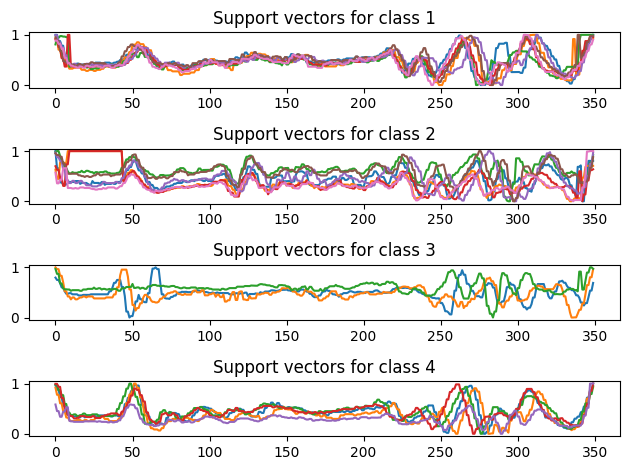

In [24]:
X_train_mm = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test_mm = TimeSeriesScalerMinMax().fit_transform(X_test)
n_classes = len(set(y_train))

clf_SVC = TimeSeriesSVC(C = 1., kernel = 'gak', gamma = 'auto', probability=True)
clf_SVC.fit(X_train_mm, y_train)
print("Correct classification rate:", clf_SVC.score(X_test_mm, y_test))
y_pred = clf_SVC.predict(X_test_mm)
y_pred_proba = clf_SVC.predict_proba(X_test_mm)
y_pred_log_proba = clf_SVC.predict_log_proba(X_test_mm)

plt.figure()
sv = clf_SVC.support_vectors_
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    plt.title('Support vectors for class %d' %cl)
    for ts in sv[i]:
        plt.plot(ts.ravel())

plt.tight_layout()
plt.show()


## ECG (classification)

### 2 Загрузка данных
Данные уже разделены на тренировочную и тестовую выборки

In [6]:
X_train, X_test, y_train, y_test = load_data_ecg()

(14667, 187) (14667,)
(9826, 187) (9826,)


##### sktime KNeighborsTimeSeriesClassifier

In [7]:
clf_knn = KNeighborsTimeSeriesClassifier(metric="euclidean")
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
f1_score(y_test, y_pred, average = 'macro')

0.7941289450540209

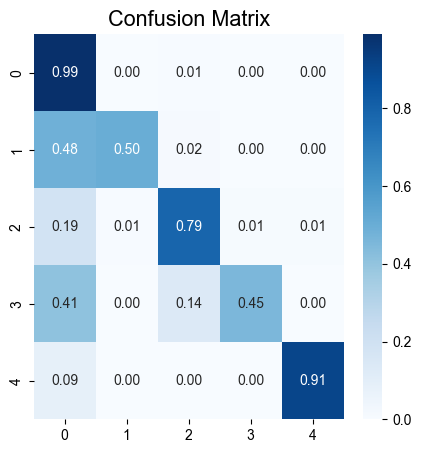

In [10]:
cm_plot(y_test, y_pred)

Попробуем улучшить качество работы модели, применив преобразование данных. Это попытка борьбы с пустыми значениями

In [18]:
X_train, X_test, y_train, y_test = load_data_ecg()

(14667, 187) (14667,)
(9826, 187) (9826,)


In [22]:
ts_scaler = TimeSeriesScalerMeanVariance()
X_train_mv = ts_scaler.fit_transform(X_train)
X_test_mv = ts_scaler.fit_transform(X_test)

In [23]:
clf_knn = KNeighborsTimeSeriesClassifier(metric="euclidean")
clf_knn.fit(X_train_mv, y_train)
y_pred = clf_knn.predict(X_test_mv)
f1_score(y_test, y_pred, average = 'macro')

0.8018062213298501

In [24]:
ts_scaler = TimeSeriesScalerMinMax(value_range=(0, 1))
X_train_mm = ts_scaler.fit_transform(X_train)
X_test_mm = ts_scaler.fit_transform(X_test)

In [25]:
clf_knn = KNeighborsTimeSeriesClassifier(metric="euclidean")
clf_knn.fit(X_train_mm, y_train)
y_pred = clf_knn.predict(X_test_mm)
f1_score(y_test, y_pred, average = 'macro')

0.7950500477663588

##### sktime TimeSeriesForestClassifier

In [26]:
best_est = 3
best_f1 = 0

for est in tqdm(range(5, 42, 2)):
    for min_interval in range(3, 20):
        clf = TimeSeriesForestClassifier(n_estimators=est, min_interval=min_interval)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average = 'macro')

        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_min_interval = min_interval


100%|██████████| 19/19 [10:27:01<00:00, 1980.09s/it]  


In [27]:
print('best_f1', best_f1)
print('best_est', best_est)
print('best_min_interval: ', best_min_interval)

best_f1 0.8164492524800023
best_est 35
best_min_interval:  13


In [28]:
clf = TimeSeriesForestClassifier(n_estimators=best_est, min_interval=best_min_interval)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.7987845432295221

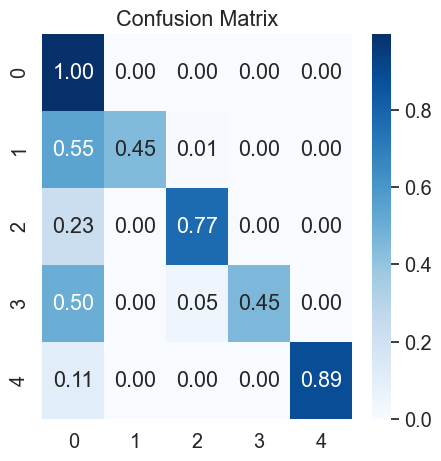

In [29]:
cm_plot(y_test, y_pred)

Предобработка с использованием StandardScaler

In [10]:
X_train, X_test, y_train, y_test = load_data_ecg()

scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.fit_transform(X_test)

n_classes = y_train.shape[0]

model = Sequential()
model.add(Flatten(input_shape = X_train.shape[1:]))
model.add(Dense(50, kernel_initializer='lecun_normal', activation='relu')) # 
model.add(Dense(50,  kernel_initializer='lecun_normal', activation='relu')) # kernel_initializer='lecun_normal'
model.add(Dense(n_classes, activation='relu')) # kernel_initializer='lecun_normal'
optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

(14667, 187) (14667,)
(9826, 187) (9826,)


### Sktime FourierTransform  
http://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.series.fourier.FourierTransform.html

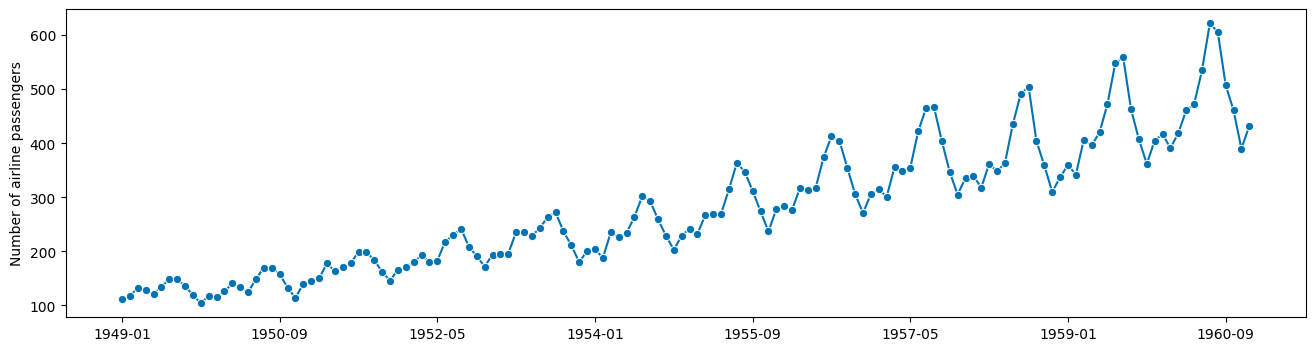

In [11]:
y = load_airline()
fig, ax = plot_series(y) 

In [12]:
from sktime.transformations.series.fourier import FourierTransform
X = load_airline()
transformer = FourierTransform()
X_ft = transformer.fit_transform(X)

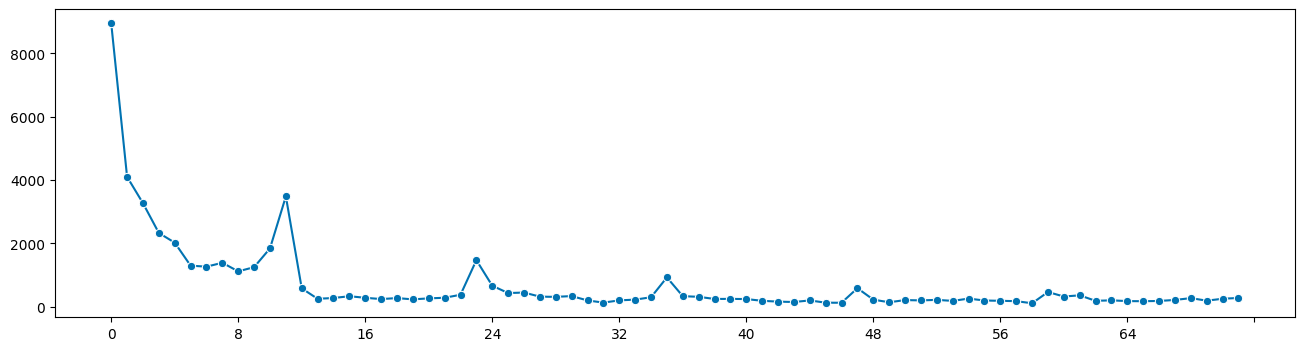

In [14]:
fig, ax = plot_series(X_ft) 

# pyts

### Plotting a time series

(14667, 187) (14667,)
(9826, 187) (9826,)


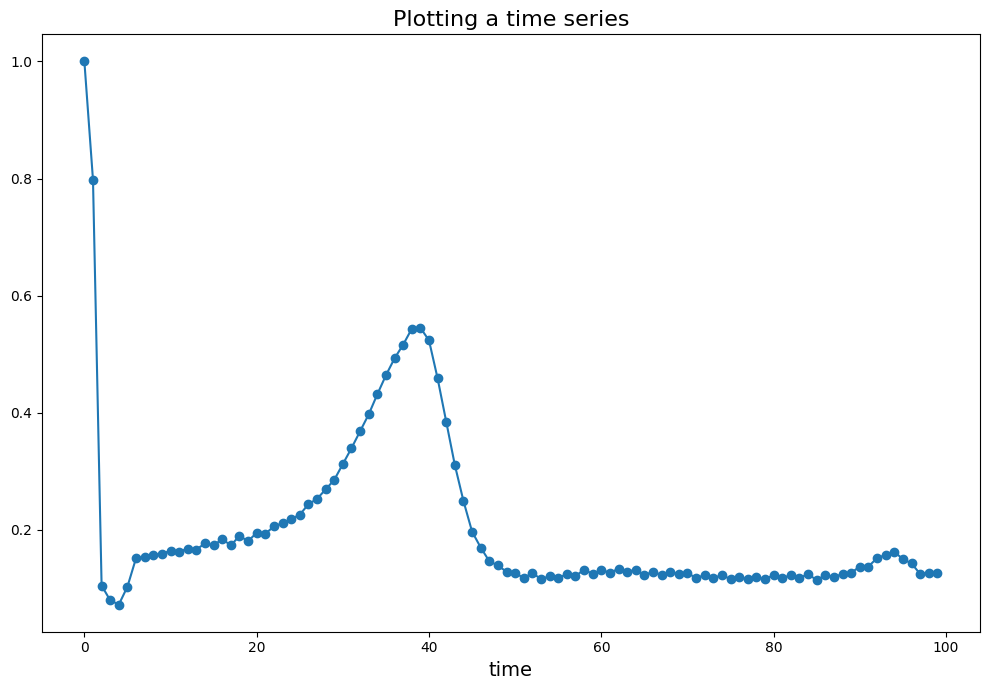

In [67]:
# Load dataset
X_train, y_train, X_test, y_test = load_data_ecg()
# Parameters
n_samples, n_timestamps = X.shape[0], X.shape[1]
# Plot the first time series
plt.figure(figsize=(10, 7))
plt.plot(X_train[0][0:100], 'o-') # Разделил на 2 части. 1-я часть
#plt.xticks(np.arange(0, 200, step=10)) 
plt.xlabel('time', fontsize = 14)
plt.title('Plotting a time series', fontsize = 16)
plt.tight_layout()
plt.show()
# plt.plot(X_train[0][100:200], 'o-') # 2-я часть
# #plt.xticks(np.arange(0, 200, step=10))
# plt.xlabel('time', fontsize = 14)
# plt.title('Plotting a time series', fontsize = 16)
# plt.tight_layout()
# plt.show()

In [27]:
# Cгенерированный набор временных рядов
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_timestamps)
print(X)
print(X.shape)

[[-0.27071232  0.10484805  0.25052782 ...  0.05865553  1.60971428
   0.85990674]
 [-0.98520304 -0.95836832  0.44910865 ...  1.08001575 -0.75243358
   1.15879497]
 [ 0.75087133 -1.26271269 -0.79070053 ... -1.55421805  0.27262686
  -0.5656834 ]
 ...
 [ 0.73632242 -0.00927992 -0.9345671  ... -0.27277572 -0.46268825
   0.89717774]
 [-0.43742642  0.34974187 -0.89564844 ... -0.67783247  0.89804235
   1.47615945]
 [ 0.91443154 -1.0750599  -0.26824473 ...  0.19138018  0.69816674
   1.2869462 ]]
(100, 48)


In [37]:
# Некоторый датасет из пакета sktime
from sktime.datasets import load_arrow_head
X, y = load_arrow_head()
print(X.shape)
X.head()


(211, 1)


,dim_0
0,0 -1.963009 1 -1.957825 2 -1.95614...
1,0 -1.774571 1 -1.774036 2 -1.77658...
2,0 -1.866021 1 -1.841991 2 -1.83502...
3,0 -2.073758 1 -2.073301 2 -2.04460...
4,0 -1.746255 1 -1.741263 2 -1.72274...


### Approximating time series


(14667, 187) (14667,)
(9826, 187) (9826,)


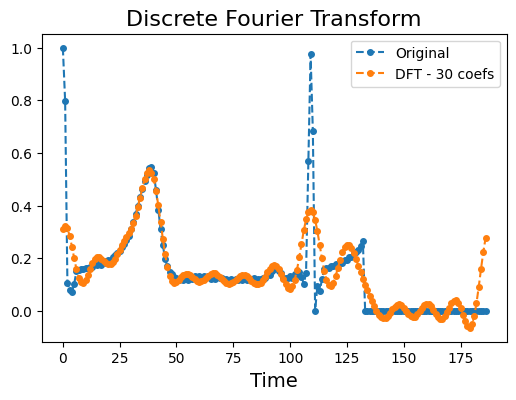

In [6]:
from pyts.approximation import DiscreteFourierTransform

# Load dataset
X_train, y_train, X_test, y_test = load_data_ecg()

# Parameters
n_samples, n_timestamps = X_train.shape[0], X_train.shape[1]

# DFT transformation (прямое преобразование Фурье)
n_coefs = 30
dft = DiscreteFourierTransform(n_coefs=n_coefs, norm_mean=False, norm_std=False)
X_train_dft = dft.fit_transform(X_train)

# Compute the inverse transformation (обратное преобразование Фурье)
if n_coefs % 2 == 0:
    real_idx = np.arange(1, n_coefs, 2)
    imag_idx = np.arange(2, n_coefs, 2)
    X_train_dft_new = np.c_[
        X_train_dft[:, :1],
        X_train_dft[:, real_idx] + 1j * np.c_[X_train_dft[:, imag_idx],
                                        np.zeros((n_samples, ))]
    ]
else:
    real_idx = np.arange(1, n_coefs, 2)
    imag_idx = np.arange(2, n_coefs + 1, 2)
    X_train_dft_new = np.c_[
        X_train_dft[:, :1],
        X_train_dft[:, real_idx] + 1j * X_train_dft[:, imag_idx]
    ]
X_train_irfft = np.fft.irfft(X_train_dft_new, n_timestamps)

# Show the results for the first time series
plt.figure(figsize=(6, 4))
plt.plot(X_train[0], 'o--', ms=4, label='Original')
plt.plot(X_train_irfft[0], 'o--', ms=4, label='DFT - {0} coefs'.format(n_coefs))
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=14)
plt.title('Discrete Fourier Transform', fontsize=16)
plt.show()

### Multiple Coefficient Binning (не работает)


In [8]:
# from pyts.approximation import MultipleCoefficientBinning

# # Load dataset
# X_train, y_train, X_test, y_test = load_data_ecg()

# # Parameters
# n_samples, n_timestamps = X_train.shape[0], X_train.shape[1]

# # MCB transformation
# n_bins = 3
# mcb = MultipleCoefficientBinning(n_bins=n_bins, strategy='quantile')
# X_train_mcb = mcb.fit_transform(X_train)

# # Show the results for two time series
# plt.figure(figsize=(6, 4))

# plt.plot(X_train[0], 'o--', ms=4, label='First time series')
# for x, y, s in zip(range(n_timestamps), X_train[0], X_train_mcb[0]):
#     plt.text(x, y, s, ha='center', va='bottom', fontsize=14, color='C0')

# plt.plot(X_train[5], 'o--', ms=4, label='Second time series')
# for x, y, s in zip(range(n_timestamps), X_train[5], X_train_mcb[5]):
#     plt.text(x, y, s, ha='center', va='bottom', fontsize=14, color='C1')

# # Plot the bin edges
# for i in range(n_bins - 1):
#     plt.hlines(mcb.bin_edges_.T[i], np.arange(n_timestamps) - 0.5,
#                np.arange(n_timestamps) + 0.5, color='g',
#                linestyles='--', linewidth=0.7)
# plt.vlines(np.arange(n_timestamps + 1) - 0.5, X_train.min(), X_train.max(),
#            linestyles='--', linewidth=0.5)

# plt.legend(loc='best', fontsize=10)
# plt.xlabel('Time', fontsize=14)
# plt.title("Multiple Coefficient Binning", fontsize=16)
# plt.show()

### Piecewise Aggregate Approximation

(14667, 187) (14667,)
(9826, 187) (9826,)


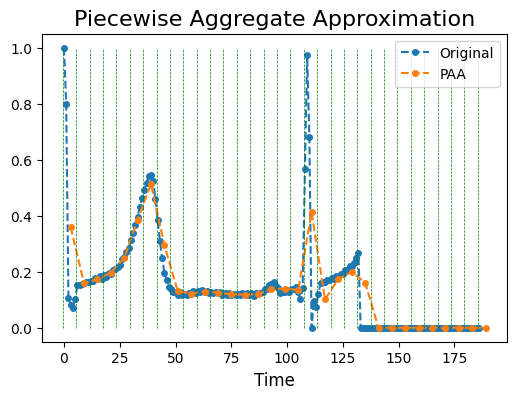

In [9]:
from pyts.approximation import PiecewiseAggregateApproximation

# Load dataset
X_train, y_train, X_test, y_test = load_data_ecg()

# Parameters
n_samples, n_timestamps = X_train.shape[0], X_train.shape[1]

# PAA transformation
window_size = 6
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_train_paa = paa.transform(X_train)

# Show the results for the first time series
plt.figure(figsize=(6, 4))
plt.plot(X_train[0], 'o--', ms=4, label='Original')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_train_paa[0], 'o--', ms=4, label='PAA')
plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5,
           X_train[0].min(), X_train[0].max(), color='g', linestyles='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.title('Piecewise Aggregate Approximation', fontsize=16)
plt.show()

### Classification algorithms
Classification algorithms can directly classify raw time series.



##### Bag-of-SFA Symbols in Vector Space (BOSSVS)

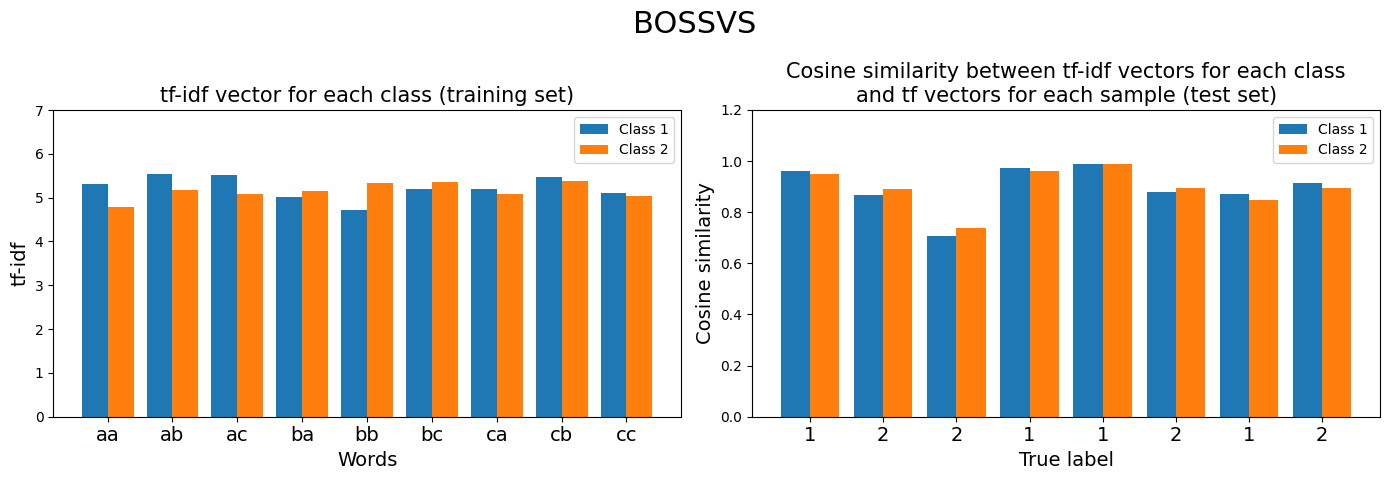

In [11]:
from pyts.classification import BOSSVS
from pyts.datasets import load_gunpoint

# Toy dataset
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

# BOSSVS transformation
bossvs = BOSSVS(word_size=2, n_bins=3, window_size=10)
bossvs.fit(X_train, y_train)
tfidf = bossvs.tfidf_
vocabulary_length = len(bossvs.vocabulary_)
X_new = bossvs.decision_function(X_test)

# Visualize the transformation
plt.figure(figsize=(14, 5))
width = 0.4

plt.subplot(121)
plt.bar(np.arange(vocabulary_length) - width / 2, tfidf[0],
        width=width, label='Class 1')
plt.bar(np.arange(vocabulary_length) + width / 2, tfidf[1],
        width=width, label='Class 2')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(bossvs.vocabulary_.get)(np.arange(vocabulary_length)),
           fontsize=14)
plt.ylim((0, 7))
plt.xlabel("Words", fontsize=14)
plt.ylabel("tf-idf", fontsize=14)
plt.title("tf-idf vector for each class (training set)", fontsize=15)
plt.legend(loc='best')

plt.subplot(122)
n_samples_plot = 8
plt.bar(np.arange(n_samples_plot) - width / 2, X_new[:n_samples_plot, 0],
        width=width, label='Class 1')
plt.bar(np.arange(n_samples_plot) + width / 2, X_new[:n_samples_plot, 1],
        width=width, label='Class 2')
plt.xticks(np.arange(n_samples_plot), y_test[:n_samples_plot], fontsize=14)
plt.ylim((0, 1.2))
plt.xlabel("True label", fontsize=14)
plt.ylabel("Cosine similarity", fontsize=14)
plt.title(("Cosine similarity between tf-idf vectors for each class\n"
           "and tf vectors for each sample (test set)"), fontsize=15)
plt.legend(loc='best')

plt.suptitle("BOSSVS", y=0.95, fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()


Learning Time Series Shapelets

e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


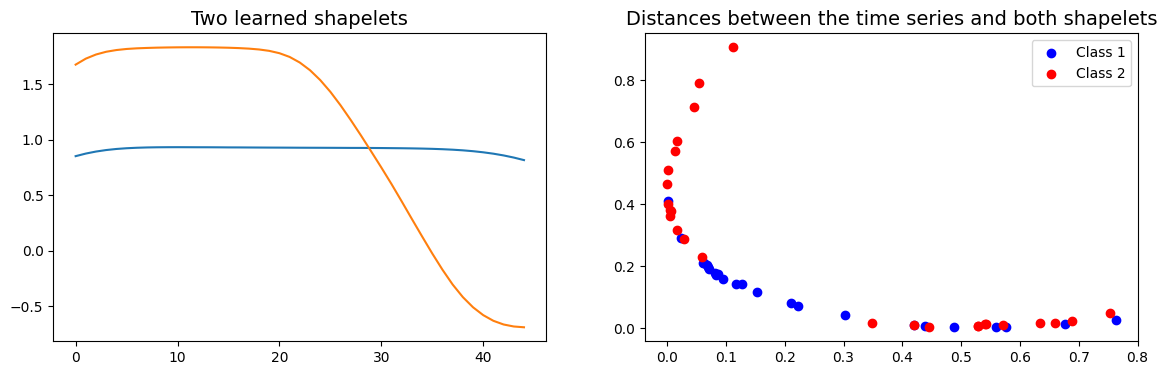

In [12]:
from pyts.classification import LearningShapelets
from pyts.utils import windowed_view

# Load the data set and fit the classifier
X, _, y, _ = load_gunpoint(return_X_y=True)
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X, y)

# Select two shapelets
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])

# Derive the distances between the time series and the shapelets
shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean(
    (X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

plt.figure(figsize=(14, 4))

# Plot the two shapelets
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot the distances
plt.subplot(1, 2, 2)
for color, label in zip('br', (1, 2)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color, label='Class {}'.format(label))
plt.title('Distances between the time series and both shapelets',
          fontsize=14)
plt.legend()
plt.show()

Symbolic Aggregate approXimation in Vector Space Model (SAX-VSM)

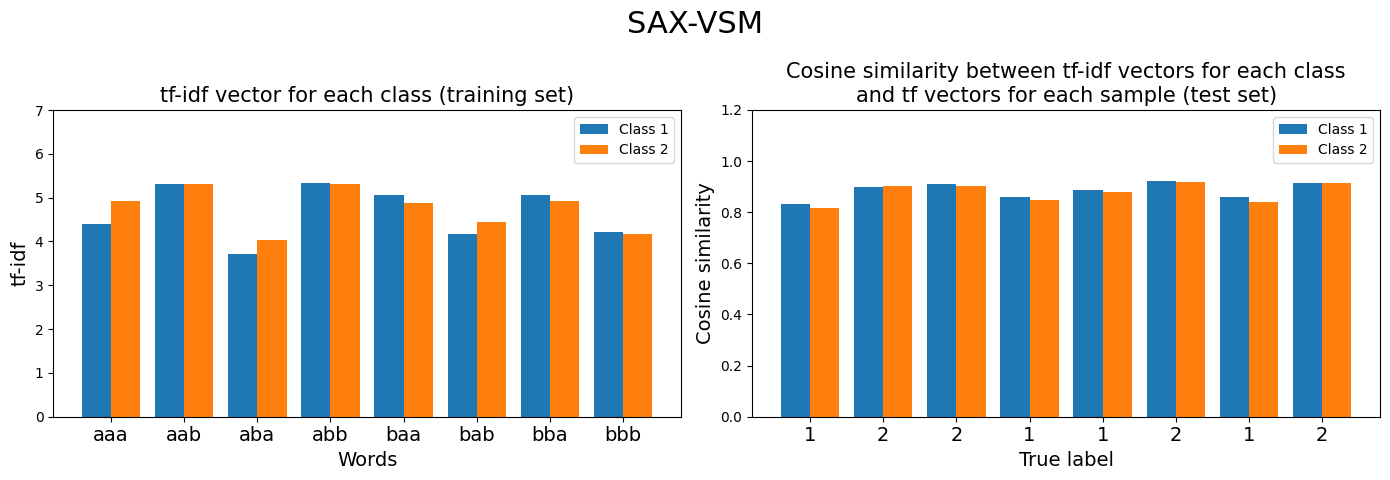

In [13]:
from pyts.classification import SAXVSM

# Toy dataset
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

# SAXVSM transformation
saxvsm = SAXVSM(window_size=15, word_size=3, n_bins=2,
                strategy='uniform')
saxvsm.fit(X_train, y_train)
tfidf = saxvsm.tfidf_
vocabulary_length = len(saxvsm.vocabulary_)
X_new = saxvsm.decision_function(X_test)

# Visualize the transformation
plt.figure(figsize=(14, 5))
width = 0.4

plt.subplot(121)
plt.bar(np.arange(vocabulary_length) - width / 2, tfidf[0],
        width=width, label='Class 1')
plt.bar(np.arange(vocabulary_length) + width / 2, tfidf[1],
        width=width, label='Class 2')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(saxvsm.vocabulary_.get)(np.arange(vocabulary_length)),
           fontsize=14)
plt.ylim((0, 7))
plt.xlabel("Words", fontsize=14)
plt.ylabel("tf-idf", fontsize=14)
plt.title("tf-idf vector for each class (training set)", fontsize=15)
plt.legend(loc='best')

plt.subplot(122)
n_samples_plot = 8
plt.bar(np.arange(n_samples_plot) - width / 2, X_new[:n_samples_plot, 0],
        width=width, label='Class 1')
plt.bar(np.arange(n_samples_plot) + width / 2, X_new[:n_samples_plot, 1],
        width=width, label='Class 2')
plt.xticks(np.arange(n_samples_plot), y_test[:n_samples_plot], fontsize=14)
plt.ylim((0, 1.2))
plt.xlabel("True label", fontsize=14)
plt.ylabel("Cosine similarity", fontsize=14)
plt.title(("Cosine similarity between tf-idf vectors for each class\n"
           "and tf vectors for each sample (test set)"), fontsize=15)
plt.legend(loc='best')

plt.suptitle("SAX-VSM", y=0.95, fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

Time Series Bag-of-Features

e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warning

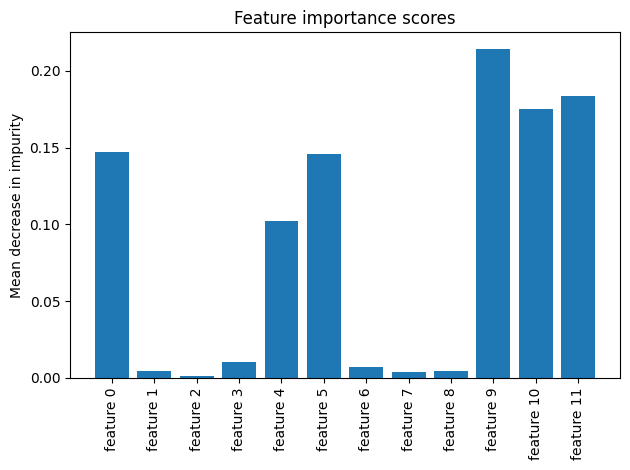

In [14]:
from pyts.classification import TSBF

X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)
clf = TSBF(random_state=43, bins=5)
clf.fit(X_train, y_train)

plt.bar(np.arange(clf.n_features_in_), clf.feature_importances_)
plt.title('Feature importance scores')
plt.xticks(np.arange(clf.n_features_in_),
           ['feature {}'.format(i) for i in range(clf.n_features_in_)],
           rotation=90)
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()
plt.show()

Time Series Forest

e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
e:\Временное хранилище\Repository\ml_timeseries\env\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


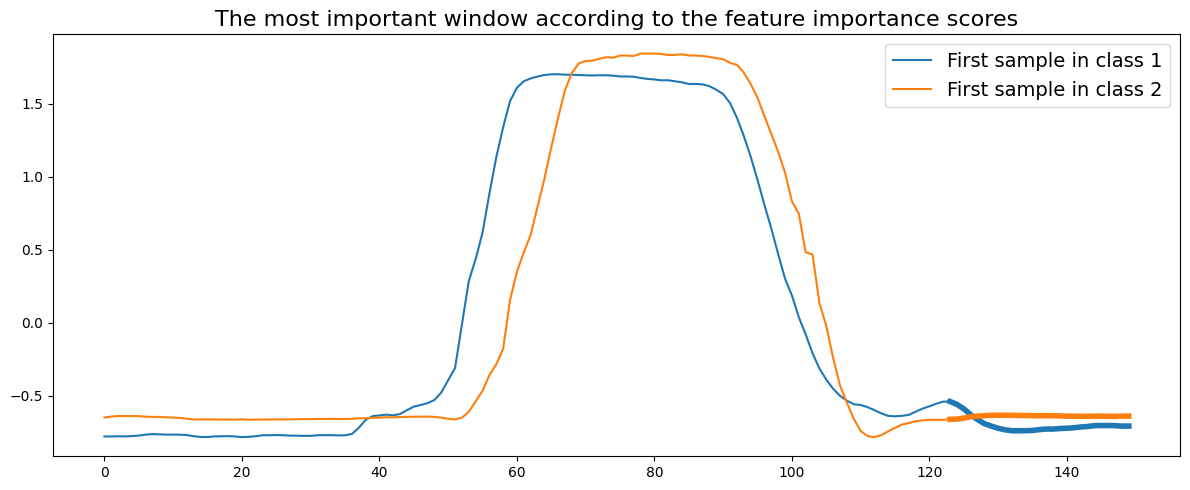

In [15]:
from pyts.classification import TimeSeriesForest

X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)
clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)

start_idxmax, end_idxmax = clf.indices_[
    np.argmax(clf.feature_importances_) // 3]

plt.figure(figsize=(12, 5))
plt.plot(X_train[y_train == 1][0], label='First sample in class 1')
plt.plot(np.arange(start_idxmax, end_idxmax),
         X_train[y_train == 1][0, start_idxmax:end_idxmax],
         color='C0', lw=4)

plt.plot(X_train[y_train == 2][0], label='First sample in class 2')
plt.plot(np.arange(start_idxmax, end_idxmax),
         X_train[y_train == 2][0, start_idxmax:end_idxmax],
         color='C1', lw=4)

plt.legend(loc='best', fontsize=14)
plt.title('The most important window according to the feature importance '
          'scores', fontsize=16)
plt.tight_layout()
plt.show()

### Dataset utilities

##### Making a Cylinder-Bell-Funnel dataset


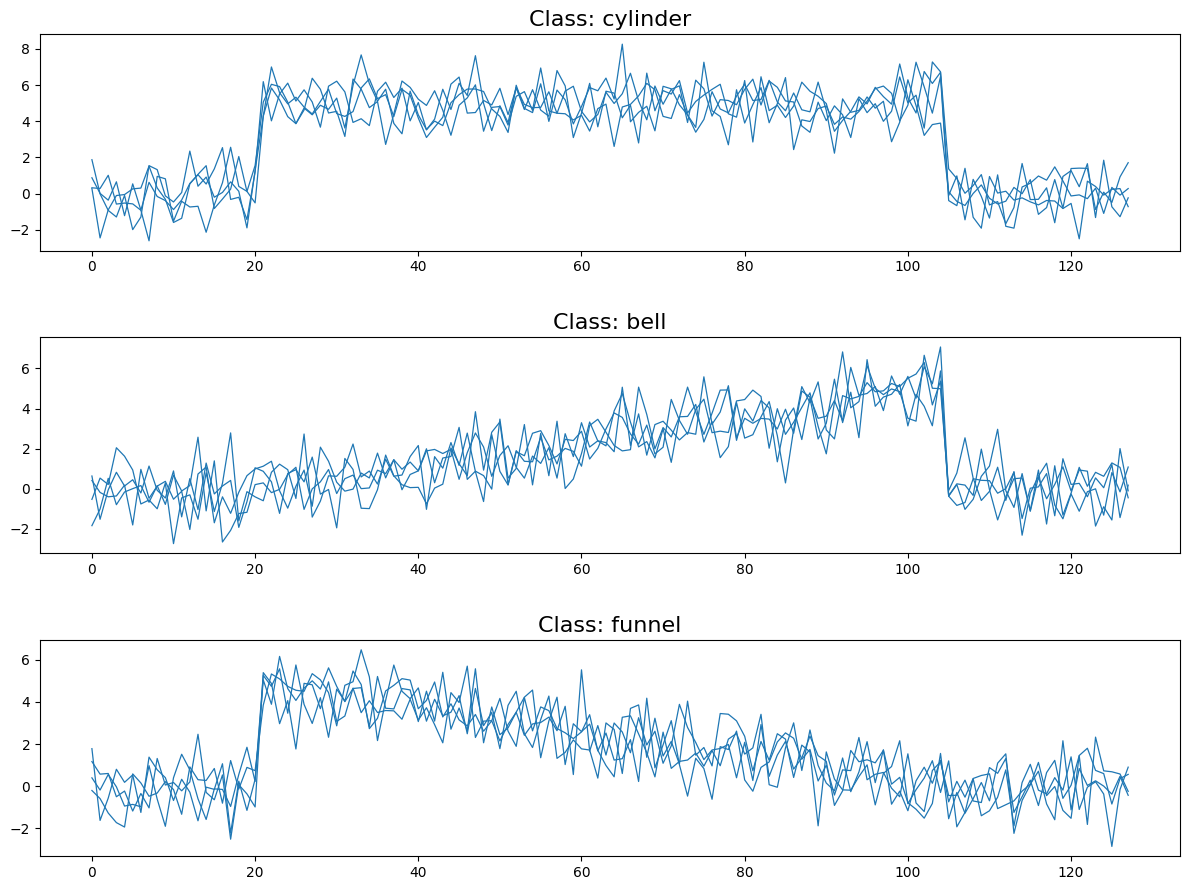

In [16]:
from pyts.datasets import make_cylinder_bell_funnel

X, y = make_cylinder_bell_funnel(n_samples=12, random_state=42)

plt.figure(figsize=(12, 9))
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

### Decomposing time series

##### Singular Spectrum Analysis


(14667, 187) (14667,)
(9826, 187) (9826,)


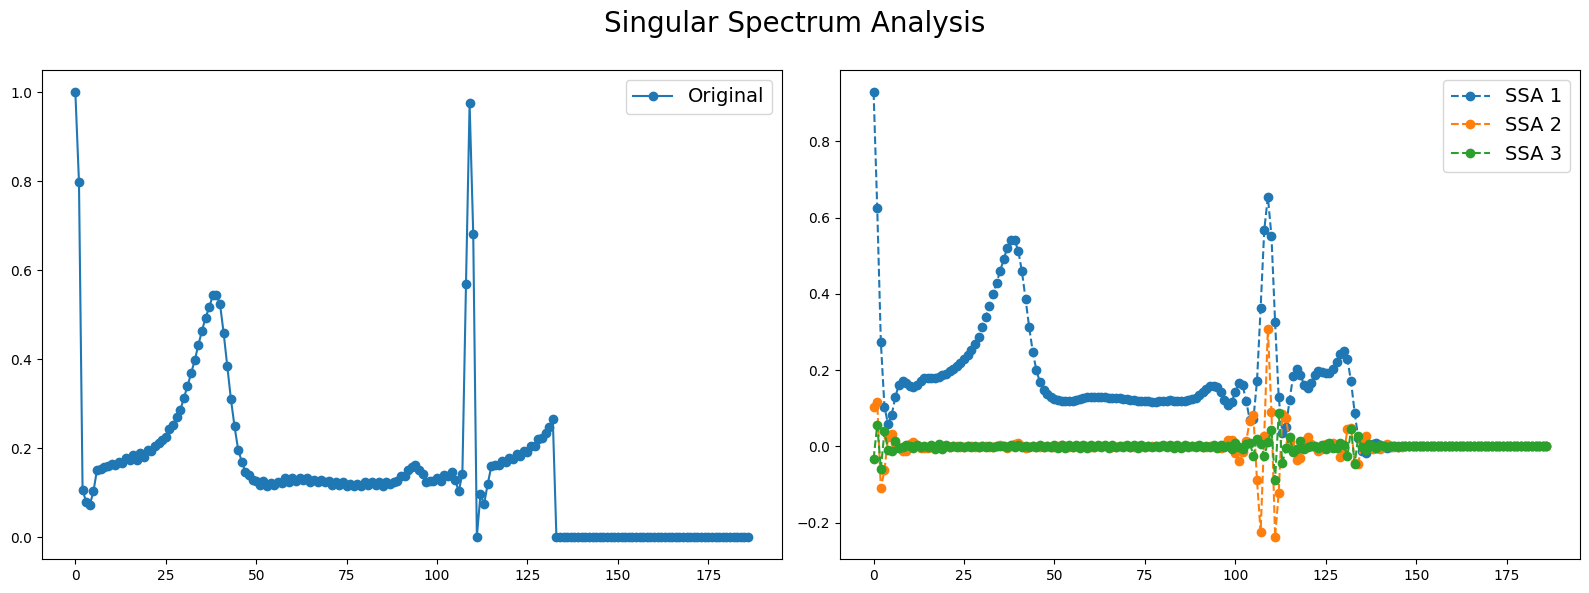

In [18]:
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
X_train, y_train, X_test, y_test = load_data_ecg()

# Parameters
n_samples, n_timestamps = X_train.shape[0], X_train.shape[1]

# We decompose the time series into three subseries
window_size = 15
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=15, groups=groups)
X_train_ssa = ssa.fit_transform(X_train)

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(X_train[0], 'o-', label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(len(groups)):
    ax2.plot(X_train_ssa[0, i], 'o--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Metrics

##### Dynamic Time Warping
https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html#sphx-glr-auto-examples-metrics-plot-dtw-py

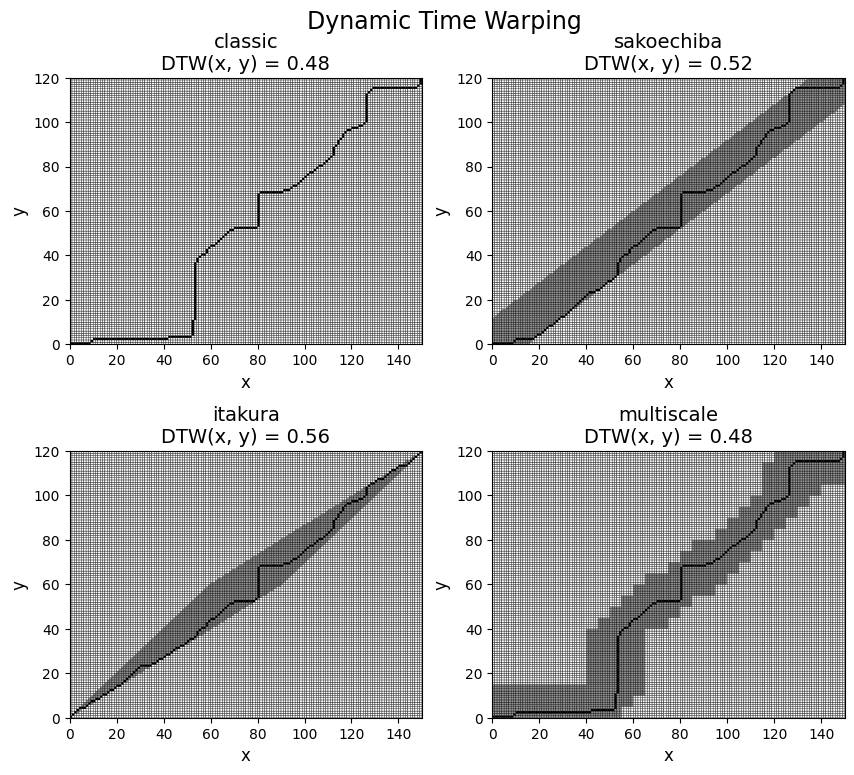

In [19]:
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)

# Parameters
X, _, _, _ = load_gunpoint(return_X_y=True)
x, y = X[0], X[1]

# To compare time series of different lengths, we remove some observations
mask = np.ones(x.size)
mask[::5] = 0
y = y[mask.astype(bool)]
n_timestamps_1, n_timestamps_2 = x.size, y.size

plt.figure(figsize=(10, 8))
timestamps_1 = np.arange(n_timestamps_1 + 1)
timestamps_2 = np.arange(n_timestamps_2 + 1)

# Dynamic Time Warping: classic
dtw_classic, path_classic = dtw(x, y, dist='square',
                                method='classic', return_path=True)
matrix_classic = np.zeros((n_timestamps_1, n_timestamps_2))
matrix_classic[tuple(path_classic)] = 1.

plt.subplot(2, 2, 1)
plt.pcolor(timestamps_1, timestamps_2, matrix_classic.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('classic', dtw_classic),
          fontsize=14)

# Dynamic Time Warping: sakoechiba
window_size = 0.1
dtw_sakoechiba, path_sakoechiba = dtw(
    x, y, dist='square', method='sakoechiba',
    options={'window_size': window_size}, return_path=True
)
band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                        window_size=window_size)
matrix_sakoechiba = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

plt.subplot(2, 2, 2)
plt.pcolor(timestamps_1, timestamps_2, matrix_sakoechiba.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('sakoechiba', dtw_sakoechiba),
          fontsize=14)

# Dynamic Time Warping: itakura
slope = 1.2
dtw_itakura, path_itakura = dtw(
    x, y, dist='square', method='itakura',
    options={'max_slope': slope}, return_path=True
)
parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                      max_slope=slope)
matrix_itakura = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
matrix_itakura[tuple(path_itakura)] = 1.
plt.subplot(2, 2, 3)
plt.pcolor(timestamps_1, timestamps_2, matrix_itakura.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('itakura', dtw_itakura),
          fontsize=14)

# Dynamic Time Warping: multiscale
resolution, radius = 5, 2
dtw_multiscale, path_multiscale = dtw(
    x, y, dist='square', method='multiscale',
    options={'resolution': resolution, 'radius': radius}, return_path=True
)

x_padded = x.reshape(-1, resolution).mean(axis=1)
y_padded = y.reshape(-1, resolution).mean(axis=1)

cost_mat_res = cost_matrix(x_padded, y_padded, dist='square', region=None)
acc_cost_mat_res = accumulated_cost_matrix(cost_mat_res)
path_res = _return_path(acc_cost_mat_res)

multiscale_region = _blurred_path_region(
    n_timestamps_1, n_timestamps_2, resolution, x_padded.size, y_padded.size,
    path_res,
    radius=radius
)
matrix_multiscale = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_multiscale[i, np.arange(*multiscale_region[:, i])] = 0.5
matrix_multiscale[tuple(path_multiscale)] = 1.

plt.subplot(2, 2, 4)
plt.pcolor(timestamps_1, timestamps_2, matrix_multiscale.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('multiscale', dtw_multiscale),
          fontsize=14)

plt.suptitle("Dynamic Time Warping", y=0.995, fontsize=17)
plt.subplots_adjust(top=0.91, hspace=0.4)
plt.show()

### Multivariate time series
Специфичные алгоритмы для многомерных временных рядов

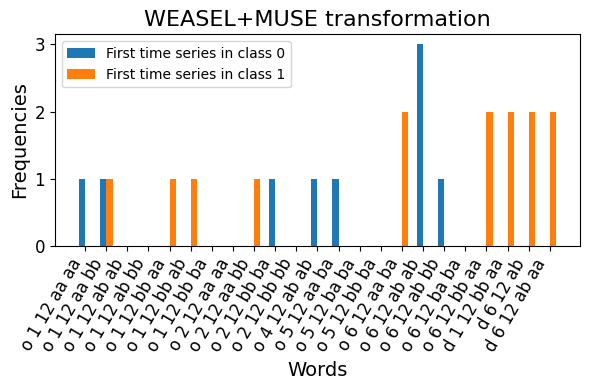

In [20]:
from pyts.datasets import load_basic_motions
from pyts.multivariate.transformation import WEASELMUSE
from sklearn.preprocessing import LabelEncoder

# Toy dataset
X_train, _, y_train, _ = load_basic_motions(return_X_y=True)
y_train = LabelEncoder().fit_transform(y_train)

# WEASEL+MUSE transformation
transformer = WEASELMUSE(word_size=2, n_bins=2, window_sizes=[12, 36],
                         chi2_threshold=15, sparse=False)
X_weasel = transformer.fit_transform(X_train, y_train)

# Visualize the transformation for the first time series
plt.figure(figsize=(6, 4))
vocabulary_length = len(transformer.vocabulary_)
width = 0.3
plt.bar(np.arange(vocabulary_length) - width / 2, X_weasel[y_train == 0][0],
        width=width, label='First time series in class 0')
plt.bar(np.arange(vocabulary_length) + width / 2, X_weasel[y_train == 1][0],
        width=width, label='First time series in class 1')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(transformer.vocabulary_.get)(
               np.arange(X_weasel[0].size)),
           fontsize=12, rotation=60, ha='right')
y_max = np.max(np.concatenate([X_weasel[y_train == 0][0],
                               X_weasel[y_train == 1][0]]))
plt.yticks(np.arange(y_max + 1), fontsize=12)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequencies", fontsize=14)
plt.title("WEASEL+MUSE transformation", fontsize=16)
plt.legend(loc='best', fontsize=10)

plt.subplots_adjust(bottom=0.27)
plt.tight_layout()
plt.show()

### Preprocessing tools


(14667, 187) (14667,)
(9826, 187) (9826,)


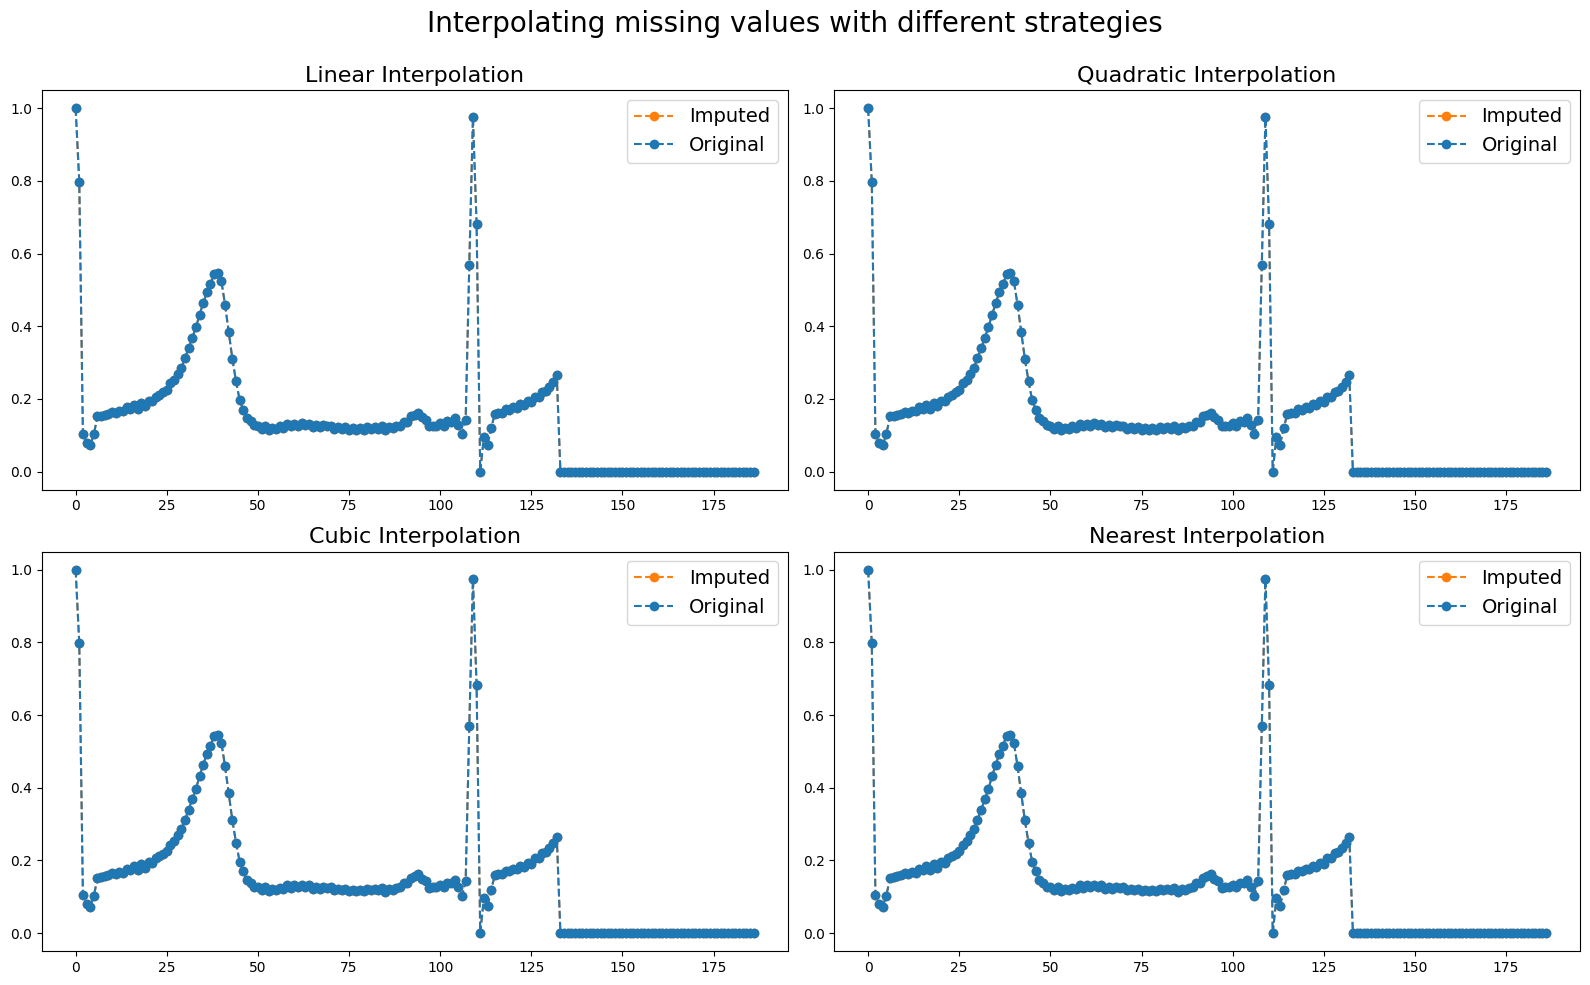

[ True]


In [27]:
from pyts.preprocessing import InterpolationImputer

# Load dataset
X_train, y_train, X_test, y_test = load_data_ecg()

# Parameters
n_samples, n_timestamps = X_train.shape[0], X_train.shape[1]

# Show the results for different strategies for the first time series
plt.figure(figsize=(16, 10))
for i, strategy in enumerate(['linear', 'quadratic', 'cubic', 'nearest']):
    imputer = InterpolationImputer(strategy=strategy)
    X_train_imputed = imputer.transform(X_train)

    plt.subplot(2, 2, i + 1)
    plt.plot(X_train_imputed[0], 'o--', color='C1', label='Imputed')
    plt.plot(X_train[0], 'o--', color='C0', label='Original')
    plt.title("{0} Interpolation".format(strategy.capitalize()), fontsize=16)
    plt.legend(loc='best', fontsize=14)

plt.suptitle('Interpolating missing values with different strategies',
             fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
print(np.unique(X_train_imputed == X_train))